# Shapley value computation

We consider a monte carlo (or quasi-monte carlo) estimation technique before jumping to the discrete uniforme shapley value as proposed by the article.

We imagine a scenario where k players each have some data and need to pool it to collaborate on tasks :

1 - MNIST digit classification with a twist : some of the data is noisy and not all players have thus the same quality or quantity of data.

2 - An XGBoost regressor : the data is squeaky clean and well adjusted for each. The goal is to compare the featue importances with those already implemented in XGB


In [7]:
import shap
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from xgboost import XGBClassifier

# Generate synthetic data
np.random.seed(42)
data = {
    'Feature1': np.random.normal(loc=0, scale=1, size=100),
    'Feature2': np.random.normal(loc=2, scale=1.5, size=100),
    'Feature3': np.random.uniform(low=-1, high=1, size=100)
}

# Create a DataFrame
df = pd.DataFrame(data)

# Generate a target variable with some dependency
df['Target'] = df['Feature1'] * 0.5 + df['Feature2'] * 1.5 + np.random.normal(loc=0, scale=1, size=100)

X = df.drop('Target', axis=1)
y = df['Target']

# transform the target to category by binning
y = pd.qcut(y, q=2, labels=False)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = XGBClassifier().fit(X_train, y_train)

# Create the explainer and SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# Calculate mean absolute SHAP values for each feature
shap_sum = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['feature', 'shap_importance']

# Sort features by importance
importance_df = importance_df.sort_values('shap_importance', ascending=False)

# Select top features (here there are only 3)
selected_features = importance_df.head(10)['feature'].tolist()

# show the results
print(importance_df)
print(selected_features)

    feature shap_importance
1  Feature2        2.975537
0  Feature1        0.516939
2  Feature3        0.379312
['Feature2', 'Feature1', 'Feature3']


# Dataset degradation

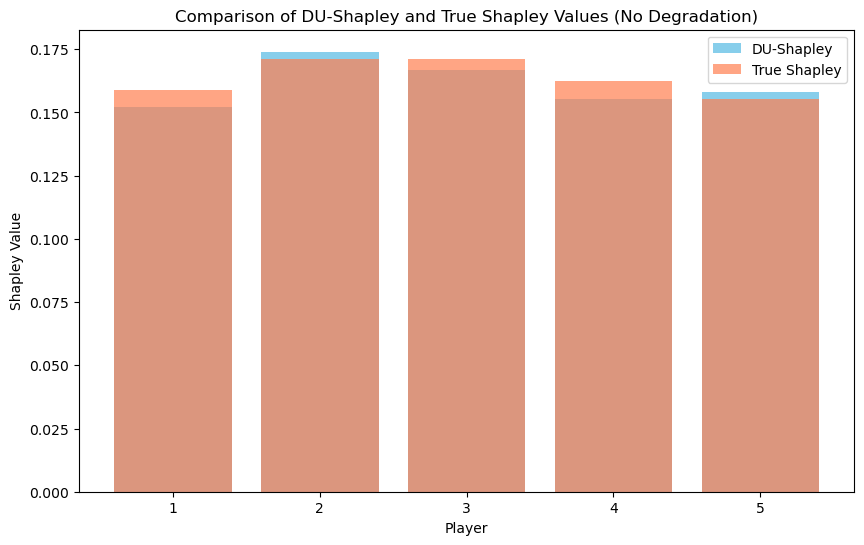

DU-Shapley Values (No Degradation): [0.15205714 0.17402857 0.16694286 0.15528571 0.15828571]
True Shapley Values (No Degradation): [0.15880714 0.17133095 0.17099762 0.16231905 0.15525952]


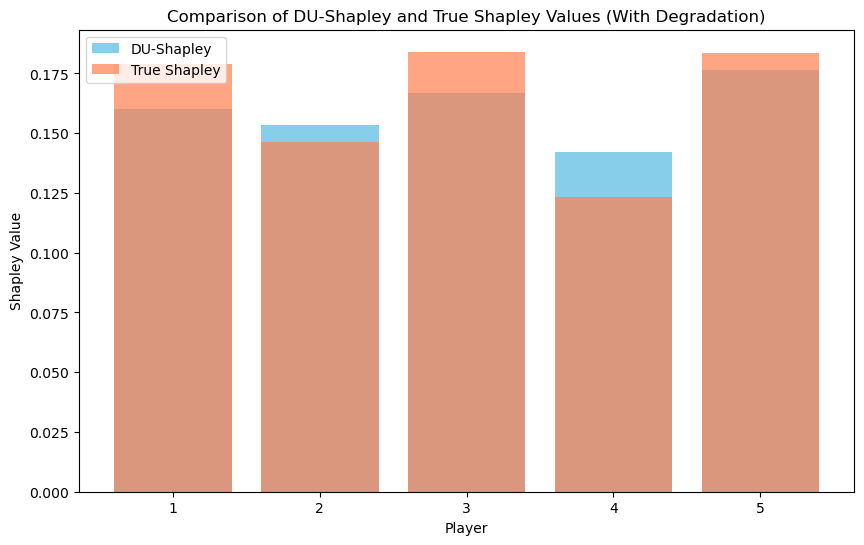

DU-Shapley Values (With Degradation): [0.16008571 0.15334286 0.16662857 0.14222857 0.1764    ]
True Shapley Values (With Degradation): [0.1788881  0.14630476 0.18406667 0.12311429 0.18334048]


In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
from utils import DU_mnist_ShapleyCalculator

# Instantiate the calculator
calculator = DU_mnist_ShapleyCalculator()

# Define number of players and data distribution
I = 5  # Reduced number of players for computational feasibility
calculator.normal_players(I=I, mean=100, std=10)  

# --- Experiment 1: No data degradation ---
# Calculate Shapley values
du_shapley_values_no_degradation = calculator.du_shapley_value()
true_shapley_values_no_degradation = calculator.calculate_true_shapley()

# Visualize and compare
plt.figure(figsize=(10, 6))
plt.bar(range(1, I + 1), du_shapley_values_no_degradation, color='skyblue', label='DU-Shapley')
plt.bar(range(1, I + 1), true_shapley_values_no_degradation, color='coral', alpha=0.7, label='True Shapley')
plt.xlabel('Player')
plt.ylabel('Shapley Value')
plt.title('Comparison of DU-Shapley and True Shapley Values (No Degradation)')
plt.xticks(range(1, I + 1))
plt.legend()
plt.show()

print("DU-Shapley Values (No Degradation):", du_shapley_values_no_degradation)
print("True Shapley Values (No Degradation):", true_shapley_values_no_degradation)

# --- Experiment 2: Data degradation for specific players ---
# Reload data (to have the original MNIST data)
calculator.load_data_normal()
calculator.normal_players(I=I, mean=100, std=10)

# Degrade data for players 2 and 4
players_to_degrade = [1, 3]  
calculator.degrade_data(players_to_degrade, degradation_type='noise', severity=3)

# Calculate Shapley values
du_shapley_values_degradation = calculator.du_shapley_value()
true_shapley_values_degradation = calculator.calculate_true_shapley()

# Visualize and compare
plt.figure(figsize=(10, 6))
plt.bar(range(1, I + 1), du_shapley_values_degradation, color='skyblue', label='DU-Shapley')
plt.bar(range(1, I + 1), true_shapley_values_degradation, color='coral', alpha=0.7, label='True Shapley')
plt.xlabel('Player')
plt.ylabel('Shapley Value')
plt.title('Comparison of DU-Shapley and True Shapley Values (With Degradation)')
plt.xticks(range(1, I + 1))
plt.legend()
plt.show()

print("DU-Shapley Values (With Degradation):", du_shapley_values_degradation)
print("True Shapley Values (With Degradation):", true_shapley_values_degradation)